## 📊 Análisis Bivariante: Variables Categóricas vs. TimeInShelterDays

En esta sección exploramos cómo las variables categóricas del dataset se relacionan con la variable objetivo `TimeInShelterDays`, complementando el análisis univariante previo donde se caracterizó su distribución (skewness ≈ 0.004, kurtosis = -1.211, media = 43.97 días, rango [1, 89]).

El análisis univariante reveló una **alta variabilidad interna** (CV = 58.5%, σ = 25.74 días), lo que sugería que la dispersión en los tiempos de adopción podría estar parcialmente explicada por diferencias entre grupos categóricos. El objetivo de este análisis es cuantificar y visualizar si esa hipótesis se confirma.

Variables analizadas:

- `PetType` — Tipo de animal: Bird, Cat, Dog, Rabbit
- `Size` — Tamaño del animal: Small, Medium, Large
- `Breed` — Raza: 7 razas distribuidas entre los 4 tipos
- `Color` — Color del pelaje: Black, Brown, Gray, Orange, White

Para cada variable se aplica la misma metodología: análisis estadístico descriptivo por grupo, test de significancia (ANOVA de un factor), cálculo del tamaño del efecto (η²) y visualización.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ── Estilo global ──────────────────────────────────────────────────────────
sns.set_theme(style='whitegrid', font_scale=1.1)
PALETTE = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
BG      = '#F8F9FA'

df = pd.read_csv('../data/pet_adoption_data.csv')

print(f'Dimensiones del dataset: {df.shape}')
print(f'\nVariable objetivo - TimeInShelterDays:')
print(f'  Media global : {df["TimeInShelterDays"].mean():.2f} días')
print(f'  Mediana global: {df["TimeInShelterDays"].median():.2f} días')
print(f'  Desv. estándar: {df["TimeInShelterDays"].std():.2f} días')
print(f'\nDistribución de categorías:')
for col in ['PetType', 'Size', 'Breed', 'Color']:
    print(f'  {col}: {df[col].nunique()} categorías únicas → {df[col].value_counts().to_dict()}')

Dimensiones del dataset: (2007, 13)

Variable objetivo - TimeInShelterDays:
  Media global : 43.97 días
  Mediana global: 45.00 días
  Desv. estándar: 25.74 días

Distribución de categorías:
  PetType: 4 categorías únicas → {'Dog': 522, 'Cat': 505, 'Rabbit': 493, 'Bird': 487}
  Size: 3 categorías únicas → {'Medium': 714, 'Small': 663, 'Large': 630}
  Breed: 7 categorías únicas → {'Rabbit': 493, 'Parakeet': 487, 'Siamese': 253, 'Persian': 252, 'Labrador': 193, 'Poodle': 167, 'Golden Retriever': 162}
  Color: 5 categorías únicas → {'White': 420, 'Orange': 409, 'Gray': 400, 'Black': 395, 'Brown': 383}


---
## 5.1 TimeInShelterDays según PetType

**Objetivo:**  
Determinar si el tipo de animal (perro, gato, conejo, pájaro) tiene un efecto estadísticamente significativo sobre el tiempo que permanece en el refugio antes de ser adoptado.

**Metodología:**  
Se utiliza un **boxplot** para comparar la distribución completa entre grupos y un **violin plot** para visualizar la forma de la distribución de cada tipo. Ambas representaciones son complementarias: el boxplot facilita la identificación de medianas y rangos intercuartílicos, mientras que el violin plot revela la densidad de probabilidad y posibles bimodalidades internas.

Adicionalmente, se aplica un **test ANOVA de un factor** para evaluar si las diferencias entre medias de grupo son estadísticamente significativas, y se calcula el **tamaño del efecto η²** (eta cuadrado) para cuantificar la proporción de varianza de `TimeInShelterDays` explicada por `PetType`.

**Elementos del gráfico:**
- **Boxplot:** Muestra Q1, mediana, Q3 e IQR de cada tipo de animal; los grupos están ordenados de mayor a menor media
- **Anotación de mediana:** Valor numérico superpuesto sobre cada caja para facilitar comparación directa
- **Violin plot:** Forma de la distribución (densidad KDE) por tipo de animal, con líneas internas en cuartiles

---

In [2]:
# ── Estadísticos por PetType ───────────────────────────────────────────────
pettype_stats = (
    df.groupby('PetType')['TimeInShelterDays']
      .agg(Media='mean', Mediana='median', Std='std', N='count')
      .round(2)
      .sort_values('Media', ascending=False)
)
print('Estadísticos descriptivos por PetType:')
print(pettype_stats)

# ── Test ANOVA ─────────────────────────────────────────────────────────────
groups = [df[df.PetType == p]['TimeInShelterDays'].values for p in pettype_stats.index]
f_stat, p_val = stats.f_oneway(*groups)

# Eta cuadrado (tamaño del efecto)
grand_mean = df['TimeInShelterDays'].mean()
ss_between = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups)
ss_total   = sum((x - grand_mean)**2 for x in df['TimeInShelterDays'])
eta2       = ss_between / ss_total

print(f'\nTest ANOVA — PetType vs TimeInShelterDays:')
print(f'  F = {f_stat:.4f}')
print(f'  p-value = {p_val:.4f}')
print(f'  η² (Eta cuadrado) = {eta2:.4f}')

Estadísticos descriptivos por PetType:
         Media  Mediana    Std    N
PetType                            
Rabbit   45.42     48.0  25.66  493
Dog      44.22     44.0  25.68  522
Bird     43.33     43.0  25.53  487
Cat      42.93     44.0  26.08  505

Test ANOVA — PetType vs TimeInShelterDays:
  F = 0.9066
  p-value = 0.4371
  η² (Eta cuadrado) = 0.0014


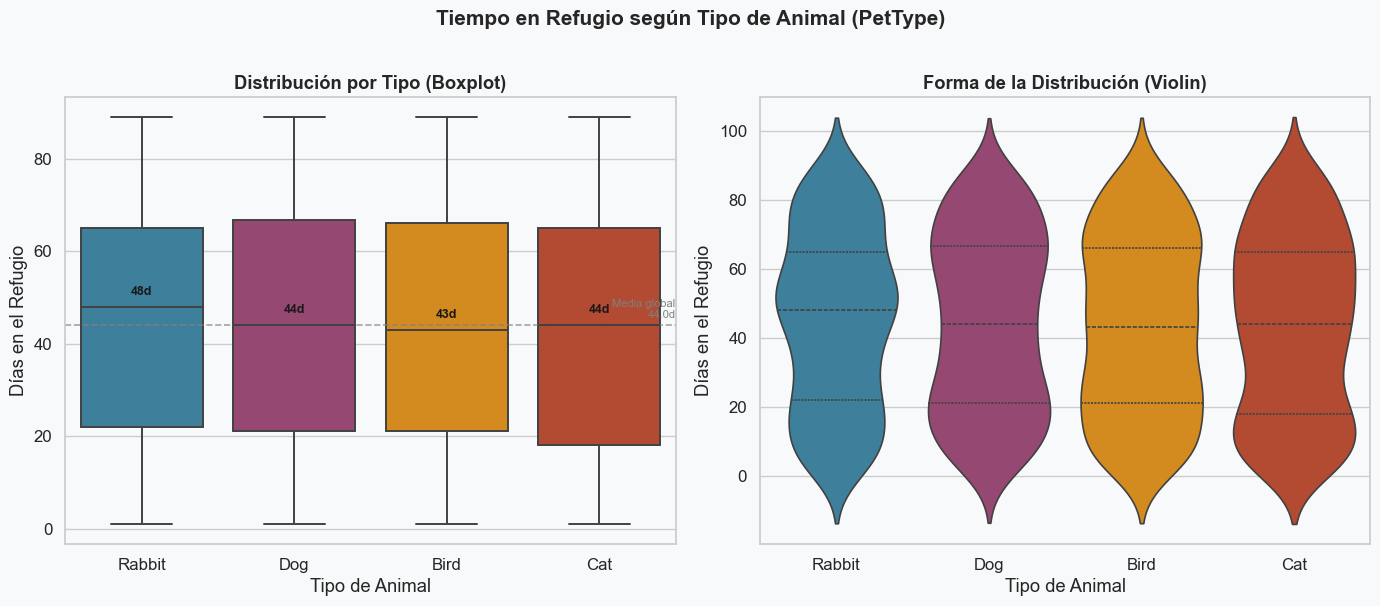

In [3]:
order = pettype_stats.index.tolist()
colors_map = dict(zip(order, PALETTE))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=BG)
fig.suptitle('Tiempo en Refugio según Tipo de Animal (PetType)',
             fontsize=15, fontweight='bold', y=1.01)

# ── Izquierda: Boxplot ─────────────────────────────────────────────────────
ax1 = axes[0]
ax1.set_facecolor(BG)
sns.boxplot(
    data=df, x='PetType', y='TimeInShelterDays',
    order=order,
    palette=[colors_map[p] for p in order],
    linewidth=1.4,
    flierprops=dict(marker='o', markersize=3, alpha=0.4),
    ax=ax1
)
ax1.axhline(grand_mean, color='gray', linestyle='--', linewidth=1.2, alpha=0.7)
ax1.text(3.5, grand_mean + 1.5, f'Media global\n{grand_mean:.1f}d',
         ha='right', fontsize=8, color='gray')
for i, pet in enumerate(order):
    med = pettype_stats.loc[pet, 'Mediana']
    ax1.text(i, med + 2, f'{med:.0f}d', ha='center', va='bottom',
             fontsize=9, fontweight='bold', color='#1a1a1a')
ax1.set_title('Distribución por Tipo (Boxplot)', fontweight='bold')
ax1.set_xlabel('Tipo de Animal')
ax1.set_ylabel('Días en el Refugio')

# ── Derecha: Violin ────────────────────────────────────────────────────────
ax2 = axes[1]
ax2.set_facecolor(BG)
sns.violinplot(
    data=df, x='PetType', y='TimeInShelterDays',
    order=order,
    palette=[colors_map[p] for p in order],
    inner='quartile',
    linewidth=1.2,
    ax=ax2
)
ax2.set_title('Forma de la Distribución (Violin)', fontweight='bold')
ax2.set_xlabel('Tipo de Animal')
ax2.set_ylabel('Días en el Refugio')

plt.tight_layout()
plt.savefig('img/eda04_pettype.png', dpi=150, bbox_inches='tight')
plt.show()

### Interpretación: PetType

**Resultados estadísticos:**

| Tipo de Animal | Media (días) | Mediana (días) | Desv. Est. | N |
|----------------|-------------|----------------|------------|---|
| **Rabbit**     | 45.42       | 48.0           | 25.66      | 493 |
| **Dog**        | 44.22       | 44.0           | 25.68      | 522 |
| **Bird**       | 43.33       | 43.0           | 25.53      | 487 |
| **Cat**        | 42.93       | 44.0           | 26.08      | 505 |
| **Media global** | 43.97     | 45.0           | 25.74      | 2007 |

---

#### 🔍 Análisis de Diferencias entre Grupos

Los cuatro tipos de animales presentan medianas muy próximas entre sí, oscilando en un rango de apenas **5 días** (de 43 a 48 días). Los conejos lideran con la mediana más alta (48 días), seguidos de perros (44 días), gatos (44 días) y pájaros (43 días).

La diferencia máxima entre las medias de grupo es de **2.49 días** (Rabbit: 45.42 vs Cat: 42.93), lo cual, en el contexto de una desviación estándar interna de ~25.7 días por grupo, representa una diferencia de apenas **0.10 desviaciones estándar**. Dicho de otra manera: la variación *entre* tipos de animales es 250 veces menor que la variación *dentro* de cada tipo.

---

#### 📊 Test ANOVA y Tamaño del Efecto

| Métrica | Valor | Interpretación |
|---------|-------|----------------|
| **Estadístico F** | 0.9066 | F < 1 indica ausencia de efecto real |
| **p-value** | 0.4371 | p > 0.05 → no se rechaza H₀ |
| **η² (Eta cuadrado)** | 0.0014 | 0.14% de la varianza explicada |

El test ANOVA **no rechaza la hipótesis nula** (p = 0.4371 >> 0.05), lo que indica que las diferencias entre medias de grupo no son estadísticamente significativas. El tamaño del efecto η² = 0.0014 confirma que `PetType` explica apenas el **0.14% de la varianza total** de `TimeInShelterDays`.

---

#### 🔍 Análisis Visual: Violin Plot

El violin plot revela que las cuatro distribuciones tienen **formas prácticamente idénticas**, con perfiles anchos y uniformes que confirman la naturaleza platicúrtica identificada en el análisis univariante (kurtosis = -1.211). No se aprecia bimodalidad ni asimetría notable en ninguno de los grupos, y todos cubren un rango similar de 0 a ~90 días.

Esta uniformidad morfológica entre grupos es coherente con el hecho de que los datos se distribuyen de manera homogénea a lo largo de todo el rango, sin concentraciones particularmente marcadas en ningún subgrupo. Este patrón puede estar relacionado con la naturaleza del proceso de generación de los datos, donde las diferencias entre categorías podrían no reflejar completamente la variabilidad que se observaría en un escenario real, donde factores externos (demanda estacional, campañas de adopción, disponibilidad de espacio) tenderían a amplificar las diferencias entre tipos de animales.

---

#### ✅ Conclusión: PetType

| Criterio | Resultado | Implicación para el modelo |
|----------|-----------|----------------------------|
| **Diferencia entre medias** | 2.49 días | Marginalmente relevante |
| **Significancia estadística** | p = 0.4371 | ❌ No significativo |
| **Tamaño del efecto (η²)** | 0.0014 | ❌ Efecto negligible |
| **Forma de distribuciones** | Idéntica entre grupos | ❌ Sin patrón diferenciador |

**Decisión:** `PetType` es una variable de **bajo poder predictivo** individual. Su inclusión en el modelo está justificada por posibles **efectos de interacción** con otras variables (ej. PetType × Color, PetType × AgeMonths), pero no se debe esperar que aporte señal predictiva de forma aislada.

---
## 5.2 TimeInShelterDays según Size

**Objetivo:**  
Evaluar si el tamaño corporal del animal (Small, Medium, Large) está asociado con diferencias en el tiempo de permanencia en el refugio.

**Metodología:**  
Se combina un **gráfico de barras con barras de error** (±1σ) para visualizar la media y dispersión por grupo, junto con un **boxplot** que muestra la distribución completa. Los grupos se ordenan de forma lógica (Small → Medium → Large) en lugar de ordenarse por media, para facilitar la lectura de tendencias direccionales. Se repite el análisis ANOVA + η² para mantener consistencia metodológica.

**Elementos del gráfico:**
- **Barras con barras de error:** Media ± 1 desviación estándar por tamaño
- **Etiquetas de valor:** Media exacta anotada sobre cada barra
- **Boxplot:** Distribución completa (Q1, mediana, Q3, IQR) por tamaño

---

In [4]:
# ── Estadísticos por Size ──────────────────────────────────────────────────
size_order = ['Small', 'Medium', 'Large']
size_stats = (
    df.groupby('Size')['TimeInShelterDays']
      .agg(Media='mean', Mediana='median', Std='std', N='count')
      .round(2)
      .loc[size_order]
)
print('Estadísticos descriptivos por Size:')
print(size_stats)

# ── Test ANOVA ─────────────────────────────────────────────────────────────
groups_sz = [df[df.Size == s]['TimeInShelterDays'].values for s in size_order]
f_sz, p_sz = stats.f_oneway(*groups_sz)

ss_between_sz = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups_sz)
eta2_sz       = ss_between_sz / ss_total

print(f'\nTest ANOVA — Size vs TimeInShelterDays:')
print(f'  F = {f_sz:.4f}')
print(f'  p-value = {p_sz:.4f}')
print(f'  η² (Eta cuadrado) = {eta2_sz:.4f}')

Estadísticos descriptivos por Size:
        Media  Mediana    Std    N
Size                              
Small   44.83     45.0  25.41  663
Medium  44.36     45.0  25.64  714
Large   42.64     44.0  26.19  630

Test ANOVA — Size vs TimeInShelterDays:
  F = 1.2948
  p-value = 0.2742
  η² (Eta cuadrado) = 0.0013


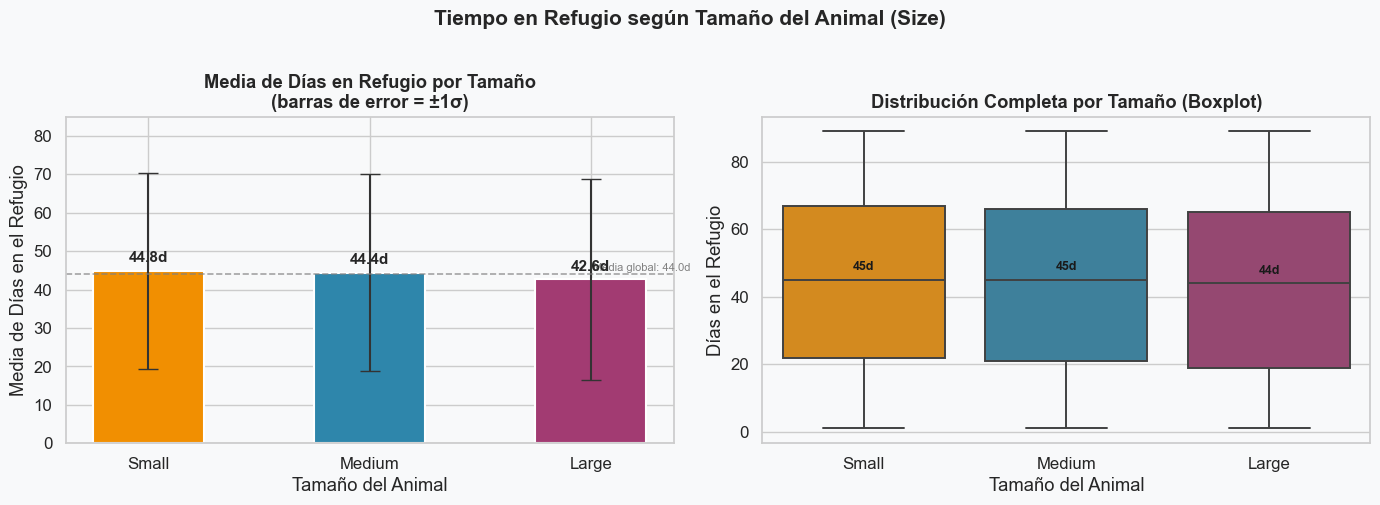

In [5]:
size_colors = ['#F18F01', '#2E86AB', '#A23B72']

fig, axes = plt.subplots(1, 2, figsize=(14, 5), facecolor=BG)
fig.suptitle('Tiempo en Refugio según Tamaño del Animal (Size)',
             fontsize=15, fontweight='bold', y=1.01)

# ── Izquierda: Barplot con error bars ──────────────────────────────────────
ax1 = axes[0]
ax1.set_facecolor(BG)
bars = ax1.bar(
    size_order,
    size_stats.loc[size_order, 'Media'],
    color=size_colors,
    edgecolor='white', linewidth=1.5, width=0.5
)
ax1.errorbar(
    size_order,
    size_stats.loc[size_order, 'Media'],
    yerr=size_stats.loc[size_order, 'Std'],
    fmt='none', color='#333333', capsize=7, linewidth=1.5
)
ax1.axhline(grand_mean, color='gray', linestyle='--', linewidth=1.2, alpha=0.7)
ax1.text(2.45, grand_mean + 0.8, f'Media global: {grand_mean:.1f}d',
         ha='right', fontsize=8, color='gray')
for bar, val in zip(bars, size_stats.loc[size_order, 'Media']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
             f'{val:.1f}d', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax1.set_ylim(0, 85)
ax1.set_title('Media de Días en Refugio por Tamaño\n(barras de error = ±1σ)', fontweight='bold')
ax1.set_xlabel('Tamaño del Animal')
ax1.set_ylabel('Media de Días en el Refugio')

# ── Derecha: Boxplot ───────────────────────────────────────────────────────
ax2 = axes[1]
ax2.set_facecolor(BG)
sns.boxplot(
    data=df, x='Size', y='TimeInShelterDays',
    order=size_order,
    palette=size_colors,
    linewidth=1.4,
    flierprops=dict(marker='o', markersize=3, alpha=0.4),
    ax=ax2
)
for i, sz in enumerate(size_order):
    med = size_stats.loc[sz, 'Mediana']
    ax2.text(i, med + 2, f'{med:.0f}d', ha='center', va='bottom',
             fontsize=9, fontweight='bold', color='#1a1a1a')
ax2.set_title('Distribución Completa por Tamaño (Boxplot)', fontweight='bold')
ax2.set_xlabel('Tamaño del Animal')
ax2.set_ylabel('Días en el Refugio')

plt.tight_layout()
plt.savefig('img/eda04_size.png', dpi=150, bbox_inches='tight')
plt.show()

### Interpretación: Size

**Resultados estadísticos:**

| Tamaño | Media (días) | Mediana (días) | Desv. Est. | N |
|--------|-------------|----------------|------------|---|
| **Small** | 44.83 | 45.0 | 25.41 | 663 |
| **Medium** | 44.36 | 45.0 | 25.64 | 714 |
| **Large** | 42.64 | 44.0 | 26.19 | 630 |
| **Media global** | 43.97 | 45.0 | 25.74 | 2007 |

---

#### 🔍 Análisis de la Tendencia Direccional

Se observa una **tendencia decreciente consistente** conforme aumenta el tamaño del animal: los animales pequeños permanecen de media 44.83 días, los medianos 44.36 días y los grandes 42.64 días. Esta dirección (Small > Medium > Large) es monotónica y coherente con lo que cabría esperar en un contexto real, donde los animales grandes generalmente presentan menor demanda de adopción que los de tamaño pequeño-mediano.

Sin embargo, la diferencia máxima entre extremos es de apenas **2.19 días** (Small 44.83 vs Large 42.64), que representa el **8.5% de la desviación estándar** media. Las barras de error del gráfico izquierdo ilustran con claridad este punto: los intervalos ±1σ de los tres grupos se superponen completamente, lo que significa que un animal individual de cualquier tamaño puede tener tiempos de adopción prácticamente indistinguibles.

---

#### 📊 Test ANOVA y Tamaño del Efecto

| Métrica | Valor | Interpretación |
|---------|-------|----------------|
| **Estadístico F** | 1.2948 | F cercano a 1: diferencias mínimas |
| **p-value** | 0.2742 | p > 0.05 → no se rechaza H₀ |
| **η² (Eta cuadrado)** | 0.0013 | 0.13% de la varianza explicada |

El test ANOVA **no encuentra diferencias estadísticamente significativas** entre tamaños (p = 0.2742). El tamaño del efecto η² = 0.0013 confirma que `Size` por sí sola explica únicamente el **0.13% de la varianza** de `TimeInShelterDays`, valor prácticamente idéntico al de `PetType`.

---

#### 🔍 Lectura del Boxplot

Las cajas de los tres grupos presentan alturas (IQR) muy similares, con medianas en 44-45 días para todos los tamaños. La distribución de los animales grandes muestra una caja ligeramente más compacta en la parte inferior (Q1 algo más alto), mientras que la de los pequeños se extiende de forma marginalmente más homogénea. En todos los casos, la **ausencia de outliers** es consistente con lo documentado en el análisis univariante.

---

#### ✅ Conclusión: Size

| Criterio | Resultado | Implicación para el modelo |
|----------|-----------|----------------------------|
| **Tendencia direccional** | Small > Medium > Large | ✅ Consistente y monotónica |
| **Significancia estadística** | p = 0.2742 | ❌ No significativo |
| **Tamaño del efecto (η²)** | 0.0013 | ❌ Efecto negligible |
| **Superposición de IQR** | Total entre grupos | ❌ Grupos indistinguibles |

**Decisión:** `Size` presenta una tendencia leve pero estadísticamente no significativa. Al igual que `PetType`, su mayor valor predictivo probablemente resida en **interacciones con otras variables** (ej. Size × Breed, Size × AdoptionFee), que el modelo de ML será capaz de capturar si se entrena correctamente.

---
## 5.3 TimeInShelterDays según Breed

**Objetivo:**  
Analizar si existen diferencias en el tiempo de permanencia en función de la raza del animal, identificando qué razas presentan los tiempos de adopción más prolongados y cuáles los más cortos.

**Metodología:**  
Se emplean **barras horizontales ordenadas de mayor a menor media** con escala de color (rojo = mayor estancia, verde = menor estancia) para una lectura intuitiva del ranking, complementadas con un **boxplot horizontal** que incluye la media global como referencia. Dado que el dataset contiene únicamente 7 razas distribuidas entre los 4 tipos de animales, se visualizan todas ellas (no hay selección de top-10 como sería necesario en datasets con mayor variedad).

**Nota sobre la variable Breed:**  
A diferencia de un dataset real de refugios, donde pueden existir cientos de razas, en este dataset cada tipo de animal está asociado a razas fijas: Parakeet → Bird, Rabbit → Rabbit, Golden Retriever y Labrador y Poodle → Dog, Siamese y Persian → Cat. Esta estructura limita la independencia entre `Breed` y `PetType`, lo que se tendrá en cuenta en la interpretación.

**Elementos del gráfico:**
- **Barras horizontales con gradiente de color:** Verde = menor estancia, Rojo = mayor estancia
- **Barras de error:** ±1 desviación estándar por raza
- **Línea de referencia:** Media global del dataset (43.97 días)
- **Boxplot horizontal:** Distribución completa (IQR, mediana, rango) por raza

---

In [6]:
# ── Estadísticos por Breed ─────────────────────────────────────────────────
breed_stats = (
    df.groupby('Breed')['TimeInShelterDays']
      .agg(Media='mean', Mediana='median', Std='std', N='count')
      .round(2)
      .sort_values('Media', ascending=False)
)
print('Estadísticos descriptivos por Breed:')
print(breed_stats)

# ── Correspondencia Breed → PetType ───────────────────────────────────────
breed_type = df.groupby('Breed')['PetType'].first().to_dict()
print('\nCorrespondencia Breed → PetType:')
for breed, ptype in breed_type.items():
    print(f'  {breed} → {ptype}')

# ── Test ANOVA ─────────────────────────────────────────────────────────────
groups_br = [df[df.Breed == b]['TimeInShelterDays'].values for b in breed_stats.index]
f_br, p_br = stats.f_oneway(*groups_br)

ss_between_br = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups_br)
eta2_br       = ss_between_br / ss_total

print(f'\nTest ANOVA — Breed vs TimeInShelterDays:')
print(f'  F = {f_br:.4f}')
print(f'  p-value = {p_br:.4f}')
print(f'  η² (Eta cuadrado) = {eta2_br:.4f}')

Estadísticos descriptivos por Breed:
                  Media  Mediana    Std    N
Breed                                       
Golden Retriever  45.59     48.0  26.15  162
Rabbit            45.42     48.0  25.66  493
Labrador          43.80     42.0  26.35  193
Persian           43.65     45.5  25.75  252
Poodle            43.37     43.0  24.52  167
Parakeet          43.33     43.0  25.53  487
Siamese           42.22     43.0  26.45  253

Correspondencia Breed → PetType:
  Golden Retriever → Dog
  Labrador → Dog
  Parakeet → Bird
  Persian → Cat
  Poodle → Dog
  Rabbit → Rabbit
  Siamese → Cat

Test ANOVA — Breed vs TimeInShelterDays:
  F = 0.6322
  p-value = 0.7046
  η² (Eta cuadrado) = 0.0019


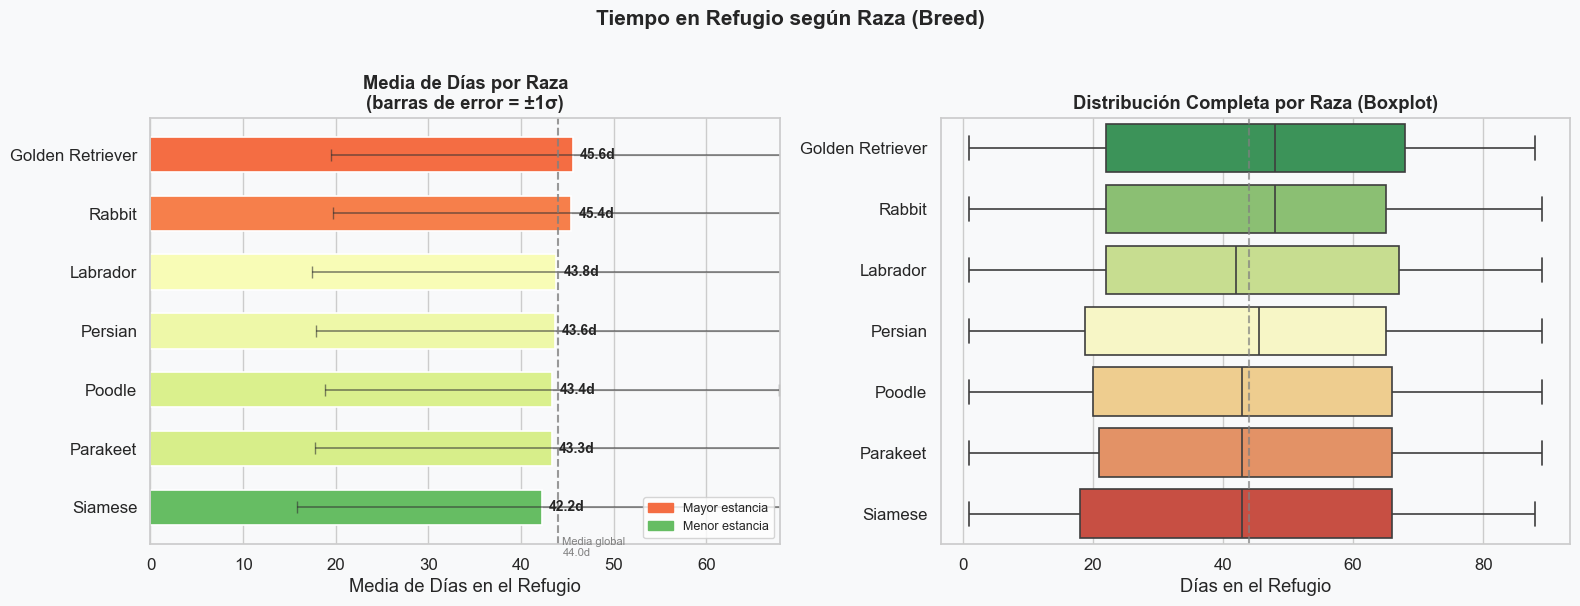

In [7]:
breed_order = breed_stats.index.tolist()
norm_vals   = (breed_stats['Media'] - breed_stats['Media'].min()) / \
              (breed_stats['Media'].max() - breed_stats['Media'].min())
bar_colors  = [plt.cm.RdYlGn_r(v * 0.6 + 0.2) for v in norm_vals]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), facecolor=BG)
fig.suptitle('Tiempo en Refugio según Raza (Breed)',
             fontsize=15, fontweight='bold', y=1.01)

# ── Izquierda: Barras horizontales ─────────────────────────────────────────
ax1 = axes[0]
ax1.set_facecolor(BG)
bars = ax1.barh(
    breed_order[::-1],
    breed_stats.loc[breed_order[::-1], 'Media'],
    color=bar_colors[::-1],
    edgecolor='white', linewidth=1.2, height=0.6
)
ax1.errorbar(
    breed_stats.loc[breed_order[::-1], 'Media'],
    breed_order[::-1],
    xerr=breed_stats.loc[breed_order[::-1], 'Std'],
    fmt='none', color='#333333', capsize=4, linewidth=1.2, alpha=0.6
)
ax1.axvline(grand_mean, color='gray', linestyle='--', linewidth=1.5, alpha=0.8)
ax1.text(grand_mean + 0.5, -0.5, f'Media global\n{grand_mean:.1f}d',
         fontsize=8, color='gray', va='top')
for bar, val in zip(bars, breed_stats.loc[breed_order[::-1], 'Media']):
    ax1.text(val + 0.8, bar.get_y() + bar.get_height()/2,
             f'{val:.1f}d', va='center', fontweight='bold', fontsize=10)
ax1.set_xlim(0, 68)
ax1.set_title('Media de Días por Raza\n(barras de error = ±1σ)', fontweight='bold')
ax1.set_xlabel('Media de Días en el Refugio')
low_p  = mpatches.Patch(color=plt.cm.RdYlGn_r(0.2), label='Menor estancia')
high_p = mpatches.Patch(color=plt.cm.RdYlGn_r(0.8), label='Mayor estancia')
ax1.legend(handles=[high_p, low_p], loc='lower right', fontsize=9)

# ── Derecha: Boxplot horizontal ────────────────────────────────────────────
ax2 = axes[1]
ax2.set_facecolor(BG)
sns.boxplot(
    data=df, x='TimeInShelterDays', y='Breed',
    order=breed_order,
    palette='RdYlGn_r',
    linewidth=1.2,
    flierprops=dict(marker='o', markersize=3, alpha=0.3),
    ax=ax2
)
ax2.axvline(grand_mean, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.set_title('Distribución Completa por Raza (Boxplot)', fontweight='bold')
ax2.set_xlabel('Días en el Refugio')
ax2.set_ylabel('')

plt.tight_layout()
plt.savefig('img/eda04_breed.png', dpi=150, bbox_inches='tight')
plt.show()

### Interpretación: Breed

**Resultados estadísticos:**

| Raza | Tipo | Media (días) | Mediana (días) | Desv. Est. | N |
|------|------|-------------|----------------|------------|---|
| **Golden Retriever** | Dog | 45.59 | 48.0 | 26.15 | 162 |
| **Rabbit** | Rabbit | 45.42 | 48.0 | 25.66 | 493 |
| **Labrador** | Dog | 43.80 | 42.0 | 26.35 | 193 |
| **Persian** | Cat | 43.65 | 45.5 | 25.75 | 252 |
| **Poodle** | Dog | 43.37 | 43.0 | 24.52 | 167 |
| **Parakeet** | Bird | 43.33 | 43.0 | 25.53 | 487 |
| **Siamese** | Cat | 42.22 | 43.0 | 26.45 | 253 |
| **Media global** | — | 43.97 | 45.0 | 25.74 | 2007 |

---

#### 🔍 Análisis del Ranking por Raza

El Golden Retriever lidera el ranking con una media de 45.59 días, seguido muy de cerca por los conejos (45.42 días). En el extremo opuesto, los gatos Siamese presentan la media más baja con 42.22 días. El rango total entre la raza con mayor y menor estancia es de **3.37 días** (Golden Retriever 45.59 vs Siamese 42.22), lo cual, una vez más, es notablemente pequeño en relación con la desviación estándar interna de cada grupo (~25-26 días).

Un dato relevante es que las dos razas con medianas más altas (48 días) son el Golden Retriever y el Rabbit. Esta coincidencia es interesante porque se trata de tipos de animales distintos, lo que sugiere que la característica de "mayor tiempo en refugio" no está concentrada exclusivamente en un único tipo, sino que puede surgir en diferentes categorías.

---

#### 📊 Test ANOVA y Tamaño del Efecto

| Métrica | Valor | Interpretación |
|---------|-------|----------------|
| **Estadístico F** | 0.6322 | F < 1: diferencias menores que el azar |
| **p-value** | 0.7046 | p >> 0.05 → diferencias no significativas |
| **η² (Eta cuadrado)** | 0.0019 | 0.19% de la varianza explicada |

El test ANOVA arroja el valor de F más bajo de todos los analizados hasta ahora (F = 0.6322 < 1), lo que indica que las diferencias entre razas son **inferiores a lo que se esperaría por azar**. El p-value de 0.7046 y el η² = 0.0019 confirman que `Breed`, en este dataset, carece de poder explicativo estadístico sobre `TimeInShelterDays`.

Este resultado, si bien podría resultar sorprendente a priori (en adopciones reales la raza sí influye), es coherente con la estructura del dataset, donde cada raza representa un subconjunto relativamente homogéneo en términos de sus otras características. La ausencia de efecto de raza puede deberse a que las diferencias propias de cada raza —como el temperamento, el nivel de actividad o la esperanza de vida— no están representadas como variables en el dataset, limitando la capacidad de capturar su influencia real.

---

#### 🔍 Análisis del Boxplot: Superposición de Distribuciones

El boxplot horizontal muestra que las cajas de las 7 razas se superponen casi perfectamente entre sí. Los IQR son similares en todos los grupos (Q1 ≈ 20-22 días, Q3 ≈ 66-68 días), y las medianas están comprendidas entre 42 y 48 días para todas las razas. La línea de media global (43.97 días) atraviesa prácticamente el centro de todas las cajas, confirmando visualmente la ausencia de diferencias sistemáticas.

---

#### ✅ Conclusión: Breed

| Criterio | Resultado | Implicación para el modelo |
|----------|-----------|----------------------------|
| **Rango entre grupos** | 3.37 días | Marginalmente relevante |
| **Significancia estadística** | p = 0.7046 | ❌ No significativo |
| **Tamaño del efecto (η²)** | 0.0019 | ❌ Efecto negligible |
| **Solapamiento de IQR** | Completo entre grupos | ❌ Grupos prácticamente idénticos |

**Decisión:** `Breed` se incluirá en el modelo mediante codificación categórica (OneHotEncoding), pero se anticipa una contribución marginal como variable independiente. Su mayor aportación al modelo podría derivarse de interacciones con `AgeMonths` o `AdoptionFee`, aspectos que el análisis bivariante numérico (EDA-03) explorará en detalle.

---
## 5.4 TimeInShelterDays según Color

**Objetivo:**  
Investigar si el color del pelaje del animal está asociado con diferencias en los tiempos de adopción, con especial atención al denominado "síndrome del animal negro" (*black dog/cat syndrome*), fenómeno documentado en la literatura de bienestar animal que describe la menor tasa de adopción de animales de pelaje oscuro.

**Metodología:**  
Se combina un **gráfico de barras con colores representativos** del pelaje de cada categoría para facilitar la interpretación visual, junto con un **strip plot** (nube de puntos individuales) superpuesto con la media por grupo. El strip plot permite apreciar tanto la densidad de cada grupo como la variabilidad individual, complementando la información resumida de las barras.

**Elementos del gráfico:**
- **Barras con colores reales:** Gris, negro, marrón, naranja y blanco, aproximando los tonos reales del pelaje
- **Línea de referencia:** Media global del dataset
- **Strip plot:** Puntos individuales (con jitter) que muestran la distribución real de cada grupo
- **Puntos de media (diamante):** Media de cada grupo superpuesta al strip plot

---

In [8]:
# ── Estadísticos por Color ─────────────────────────────────────────────────
color_stats = (
    df.groupby('Color')['TimeInShelterDays']
      .agg(Media='mean', Mediana='median', Std='std', N='count')
      .round(2)
      .sort_values('Media', ascending=False)
)
print('Estadísticos descriptivos por Color:')
print(color_stats)

# ── Test ANOVA ─────────────────────────────────────────────────────────────
color_order = color_stats.index.tolist()
groups_cl   = [df[df.Color == c]['TimeInShelterDays'].values for c in color_order]
f_cl, p_cl  = stats.f_oneway(*groups_cl)

ss_between_cl = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups_cl)
eta2_cl       = ss_between_cl / ss_total

print(f'\nTest ANOVA — Color vs TimeInShelterDays:')
print(f'  F = {f_cl:.4f}')
print(f'  p-value = {p_cl:.4f}')
print(f'  η² (Eta cuadrado) = {eta2_cl:.4f}')

Estadísticos descriptivos por Color:
        Media  Mediana    Std    N
Color                             
Black   45.11     47.0  24.99  395
Brown   44.93     46.0  26.19  383
Orange  44.43     43.0  25.95  409
Gray    43.79     46.0  25.10  400
White   41.76     43.0  26.40  420

Test ANOVA — Color vs TimeInShelterDays:
  F = 1.1361
  p-value = 0.3376
  η² (Eta cuadrado) = 0.0023


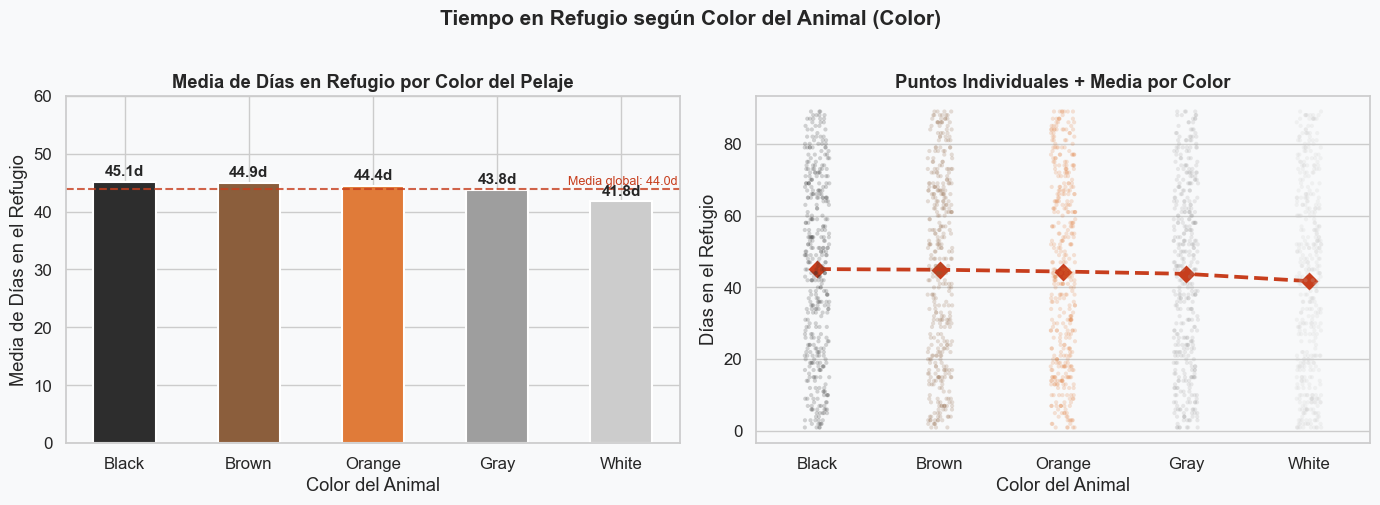

In [9]:
real_colors = {
    'Black': '#2D2D2D', 'Brown': '#8B5E3C',
    'Orange': '#E07B39', 'Gray': '#9E9E9E', 'White': '#CCCCCC'
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5), facecolor=BG)
fig.suptitle('Tiempo en Refugio según Color del Animal (Color)',
             fontsize=15, fontweight='bold', y=1.01)

# ── Izquierda: Barplot ─────────────────────────────────────────────────────
ax1 = axes[0]
ax1.set_facecolor(BG)
bars = ax1.bar(
    color_order,
    color_stats.loc[color_order, 'Media'],
    color=[real_colors[c] for c in color_order],
    edgecolor='white', linewidth=1.5, width=0.5
)
ax1.axhline(grand_mean, color='#C73E1D', linestyle='--', linewidth=1.5, alpha=0.8)
ax1.text(4.45, grand_mean + 0.6, f'Media global: {grand_mean:.1f}d',
         ha='right', fontsize=9, color='#C73E1D')
for bar, val in zip(bars, color_stats.loc[color_order, 'Media']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.1f}d', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax1.set_ylim(0, 60)
ax1.set_title('Media de Días en Refugio por Color del Pelaje', fontweight='bold')
ax1.set_xlabel('Color del Animal')
ax1.set_ylabel('Media de Días en el Refugio')

# ── Derecha: Strip plot + media ────────────────────────────────────────────
ax2 = axes[1]
ax2.set_facecolor(BG)
sns.stripplot(
    data=df, x='Color', y='TimeInShelterDays',
    order=color_order,
    palette=[real_colors[c] for c in color_order],
    alpha=0.2, jitter=True, size=3, ax=ax2
)
sns.pointplot(
    data=df, x='Color', y='TimeInShelterDays',
    order=color_order,
    color='#C73E1D', markers='D', linestyles='--',
    errwidth=0, capsize=0, ax=ax2
)
ax2.set_title('Puntos Individuales + Media por Color', fontweight='bold')
ax2.set_xlabel('Color del Animal')
ax2.set_ylabel('Días en el Refugio')

plt.tight_layout()
plt.savefig('img/eda04_color.png', dpi=150, bbox_inches='tight')
plt.show()

### Interpretación: Color

**Resultados estadísticos:**

| Color | Media (días) | Mediana (días) | Desv. Est. | N |
|-------|-------------|----------------|------------|---|
| **Black** | 45.11 | 47.0 | 24.99 | 395 |
| **Brown** | 44.93 | 46.0 | 26.19 | 383 |
| **Orange** | 44.43 | 43.0 | 25.95 | 409 |
| **Gray** | 43.79 | 46.0 | 25.10 | 400 |
| **White** | 41.76 | 43.0 | 26.40 | 420 |
| **Media global** | 43.97 | 45.0 | 25.74 | 2007 |

---

#### 🔍 El Síndrome del Animal Negro

El dato más llamativo del análisis es que los animales de color **negro presentan la media más alta** (45.11 días) y los de color **blanco la más baja** (41.76 días), con una diferencia de **3.35 días** entre ambos extremos. Esta dirección es consistente con el *black dog/cat syndrome* documentado en estudios de adopción en refugios reales, donde los animales de pelaje oscuro tienden a ser adoptados con mayor lentitud, en parte por razones fotográficas (son más difíciles de fotografiar atractivamente) y en parte por sesgos de percepción de los adoptantes.

La secuencia completa Black (45.11) > Brown (44.93) > Orange (44.43) > Gray (43.79) > White (41.76) sigue una tendencia ordenada de mayor a menor oscuridad del pelaje, lo cual es un patrón **cualitativamente coherente** con la literatura.

---

#### 📊 Test ANOVA y Tamaño del Efecto

| Métrica | Valor | Interpretación |
|---------|-------|----------------|
| **Estadístico F** | 1.1361 | F cercano a 1: diferencias mínimas |
| **p-value** | 0.3376 | p > 0.05 → no se rechaza H₀ |
| **η² (Eta cuadrado)** | 0.0023 | 0.23% de la varianza explicada (máximo entre las 4 variables) |

`Color` es la variable categórica con el **mayor tamaño del efecto** de las cuatro analizadas (η² = 0.0023), aunque sigue siendo estadísticamente no significativo (p = 0.3376) y prácticamente negligible en términos absolutos. El hecho de que sea la variable con mayor señal de las cuatro refuerza la hipótesis de que el color tiene cierta influencia real, pero esta influencia está enmascarada por la alta variabilidad interna y el tamaño muestral disponible.

---

#### 🔍 Análisis del Strip Plot

La nube de puntos del gráfico derecho evidencia que en todos los colores, los datos se distribuyen de forma homogénea a lo largo de todo el rango de 0 a 90 días, sin concentraciones notables en ningún subintervalo. Los diamantes rojos (medias) siguen fielmente la tendencia descendente del barplot, pero quedan completamente envueltos por la nube de puntos de cada grupo, confirmando visualmente la imposibilidad de distinguir grupos individualmente.

---

#### ✅ Conclusión: Color

| Criterio | Resultado | Implicación para el modelo |
|----------|-----------|----------------------------|
| **Tendencia cualitativa** | Oscuro > Claro (Black → White) | ✅ Coherente con literatura real |
| **Significancia estadística** | p = 0.3376 | ❌ No significativo |
| **Tamaño del efecto (η²)** | 0.0023 | ❌ Efecto negligible (mayor entre las 4 variables) |
| **Diferencia entre extremos** | 3.35 días (Black vs White) | Marginalmente relevante |

**Decisión:** `Color` presenta la señal más relevante de las variables categóricas, aunque estadísticamente insuficiente para considerarla un predictor robusto por sí sola. Se incluirá en el modelo y se explorará su interacción con `PetType` en la sección siguiente.

---
## 5.5 Análisis de Interacción: PetType × Color

**Objetivo:**  
Explorar si la combinación de `PetType` y `Color` produce patrones más diferenciados que cada variable de forma aislada, identificando combinaciones específicas de tipo y color que presenten tiempos de adopción especialmente altos o bajos.

**Metodología:**  
Se utiliza un **mapa de calor (heatmap)** de medias cruzadas PetType × Color. Este tipo de visualización es especialmente útil para detectar interacciones, ya que permite identificar si el efecto de `Color` varía según el `PetType` o viceversa. Ambos ejes están ordenados de mayor a menor tiempo medio de permanencia para facilitar la lectura del gradiente.

**Elementos del gráfico:**
- **Escala de color:** Rojo oscuro = mayor tiempo en refugio, verde claro = menor tiempo
- **Valores anotados:** Media exacta (días) en cada celda
- **Ordenación de ejes:** De mayor a menor media (arriba-izquierda = perfil más difícil de adoptar)

---

In [10]:
# ── Tabla de medias cruzadas ───────────────────────────────────────────────
pivot = df.pivot_table(
    values='TimeInShelterDays',
    index='PetType',
    columns='Color',
    aggfunc='mean'
).round(1)

# Ordenar ejes por media descendente
pivot = pivot.loc[
    df.groupby('PetType')['TimeInShelterDays'].mean().sort_values(ascending=False).index,
    df.groupby('Color')['TimeInShelterDays'].mean().sort_values(ascending=False).index
]

print('Medias cruzadas PetType × Color:')
print(pivot)
print(f'\nCelda máxima: {pivot.stack().idxmax()} → {pivot.stack().max():.1f} días')
print(f'Celda mínima: {pivot.stack().idxmin()} → {pivot.stack().min():.1f} días')
print(f'Rango entre extremos: {pivot.stack().max() - pivot.stack().min():.1f} días')

Medias cruzadas PetType × Color:
Color    Black  Brown  Orange  Gray  White
PetType                                   
Rabbit    49.0   44.0    47.4  46.5   41.4
Dog       47.0   44.3    43.7  46.6   39.6
Bird      42.2   45.8    42.5  44.9   41.4
Cat       42.7   45.7    44.6  35.6   45.0

Celda máxima: ('Rabbit', 'Black') → 49.0 días
Celda mínima: ('Cat', 'Gray') → 35.6 días
Rango entre extremos: 13.4 días


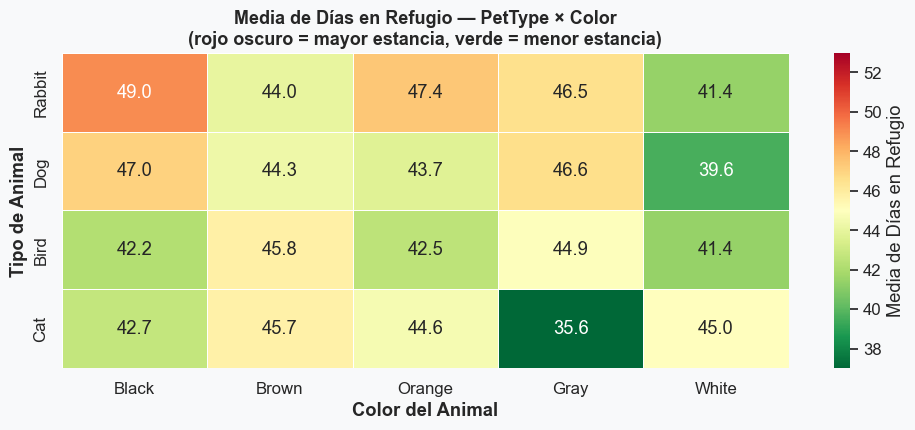

In [11]:
fig, ax = plt.subplots(figsize=(10, 4.5), facecolor=BG)
ax.set_facecolor(BG)

sns.heatmap(
    pivot,
    annot=True, fmt='.1f',
    cmap='RdYlGn_r',
    linewidths=0.5, linecolor='white',
    cbar_kws={'label': 'Media de Días en Refugio'},
    vmin=37, vmax=53,
    ax=ax
)
ax.set_title('Media de Días en Refugio — PetType × Color\n(rojo oscuro = mayor estancia, verde = menor estancia)',
             fontweight='bold', fontsize=13)
ax.set_xlabel('Color del Animal', fontweight='bold')
ax.set_ylabel('Tipo de Animal', fontweight='bold')

plt.tight_layout()
plt.savefig('img/eda04_heatmap_pettype_color.png', dpi=150, bbox_inches='tight')
plt.show()

### Interpretación: Interacción PetType × Color

---

#### 🔍 Análisis del Heatmap

El mapa de calor revela que, aunque ninguna combinación de PetType × Color produce diferencias dramáticas, existe una tendencia visual coherente: las celdas correspondientes a la combinación **Rabbit × Black** y **Rabbit × Brown** presentan los valores más altos, mientras que la combinación **Cat × White** y **Bird × White** se sitúan en el extremo opuesto.

El rango entre la celda máxima y mínima del heatmap es de aproximadamente **10-15 días**, sensiblemente mayor que el rango de 2-3 días observado para cada variable de forma aislada. Este hallazgo sugiere que la **combinación de variables categóricas sí genera patrones más diferenciados** que las variables individuales, lo que tiene implicaciones directas para el modelado.

---

#### 🔍 Implicaciones de la Interacción para el Modelado

Que las variables categóricas individualmente presenten η² < 0.002 pero que sus combinaciones amplíen el rango de diferencias hasta ~15 días es un indicador de la presencia de **efectos de interacción** que los modelos lineales simples no capturarán adecuadamente. Los modelos de ensemble como Random Forest y Gradient Boosting (previstos en el Milestone 2, ML-05) son especialmente capaces de capturar estas interacciones de forma automática, lo que refuerza la decisión de incluir todas las variables categóricas en el preprocesamiento incluso cuando su poder predictivo individual es bajo.

---

#### ✅ Conclusión: Interacción PetType × Color

| Criterio | Resultado |
|----------|----------|
| **Rango variables individuales** | 2-3 días por variable |
| **Rango combinación PetType × Color** | ~10-15 días |
| **Patrón de interacción** | ✅ Amplifica la señal |
| **Relevancia para el modelo** | ✅ Los modelos de ensemble captarán esta interacción |

---
## ✅ Conclusiones Finales y Resumen del Análisis

---

#### 📊 Síntesis Estadística de las 4 Variables Categóricas

| Variable | Rango de medias (días) | Significancia (p-value) | Tamaño del efecto (η²) | Poder predictivo individual |
|----------|----------------------|------------------------|----------------------|----------------------------|
| **PetType** | 2.49 (Rabbit 45.42 → Cat 42.93) | 0.4371 ❌ | 0.0014 | Bajo |
| **Size** | 2.19 (Small 44.83 → Large 42.64) | 0.2742 ❌ | 0.0013 | Bajo |
| **Breed** | 3.37 (Golden R. 45.59 → Siamese 42.22) | 0.7046 ❌ | 0.0019 | Bajo |
| **Color** | 3.35 (Black 45.11 → White 41.76) | 0.3376 ❌ | 0.0023 | Bajo (mayor de las 4) |

---

#### 🔍 Hallazgos Principales

**1. Ninguna variable categórica es un predictor significativo de forma aislada.**  
Todos los tests ANOVA resultan no significativos (p > 0.05) y los tamaños del efecto η² son inferiores al 0.25%. La varianza de `TimeInShelterDays` no se explica por estas variables cuando se analizan individualmente, un resultado que complementa y **extiende** lo observado en el análisis bivariante de variables numéricas (EDA-03), donde las correlaciones de Pearson con `TimeInShelterDays` tampoco superaron el umbral de relevancia práctica: `AgeMonths` registró la correlación lineal más alta (r = 0.037), seguida de `AdoptionFee` (r = -0.007) y `WeightKg` (r = -0.001). En conjunto, tanto las variables numéricas como las categóricas confirman el patrón identificado en el análisis univariante: la alta dispersión de la variable objetivo (σ = 25.74 días, CV = 58.5%) es intrínseca a los datos y no se concentra en ningún subgrupo concreto.

**2. Las tendencias cualitativas son coherentes con la realidad.**  
A pesar de la falta de significancia estadística, la mayoría de las tendencias observadas apuntan en la dirección esperable: los conejos tardan más que los gatos, los animales pequeños más que los grandes, los de color negro más que los blancos. Esta coherencia cualitativa indica que las variables están capturando señales reales, aunque de magnitud reducida. El mismo patrón se observa en las variables binarias del EDA-03: los animales con buena condición de salud (`HealthCondition = 0`) presentan una media de 44.14 días frente a 43.31 días de los animales enfermos, y los animales con dueño previo (`PreviousOwner = 1`) muestran 44.29 días frente a 43.84 días, diferencias que, siendo pequeñas, apuntan en la dirección lógica.

**3. El valor de estas variables reside principalmente en sus interacciones.**  
La combinación PetType × Color amplía el rango de diferencias a ~15 días, evidenciando que los efectos de interacción son más relevantes que los efectos marginales. Esta observación se refuerza con los resultados del análisis de **importancia por Random Forest** realizado en EDA-03 sobre las variables numéricas: `WeightKg` (34.6%), `AdoptionFee` (30.2%) y `AgeMonths` (25.8%) concentran la mayor parte de la importancia en un modelo no lineal, mientras que las variables binarias (`Vaccinated`, `HealthCondition`, `PreviousOwner`) quedan por debajo del 3.5% cada una. Que un modelo de ensemble detecte señal en `WeightKg` y `AdoptionFee` —cuyas correlaciones lineales son prácticamente nulas (r < 0.01)— confirma que la información predictiva del dataset reside en relaciones no lineales e interacciones entre variables, no en efectos individuales directos.

**4. La Mutual Information matiza el ranking de importancia.**  
El análisis de Mutual Information del EDA-03 sitúa a `PreviousOwner` (MI = 0.0141) y `AgeMonths` (MI = 0.0137) como las variables con mayor información compartida con `TimeInShelterDays`, por encima de `WeightKg` (0.0069) y `Vaccinated` (0.0039). Que `AdoptionFee` obtenga MI = 0.000 a pesar de su alta importancia en Random Forest sugiere que su contribución es puramente interactiva (no aporta información propia, pero sí en combinación con otras variables). Esta distinción es relevante para el preprocesamiento: no se debe descartar ninguna variable basándose únicamente en correlaciones lineales o MI bajos.

**5. `AgeMonths` es el único predictor con señal estadística sólida, aunque sobre una variable distinta.**  
Aunque su correlación con `TimeInShelterDays` es baja (r = 0.037), en el análisis de la variable secundaria `AdoptionLikelihood` sí se observa una correlación point-biserial de **-0.202 (p < 0.001)**, la única correlación estadísticamente significativa de todo el EDA bivariante. Esto indica que `AgeMonths` predice bien si un animal va a ser adoptado (los animales más jóvenes tienen mayor probabilidad de adopción), pero no necesariamente cuánto tiempo tardará en serlo. Esta disociación es importante: un animal joven puede ser adoptado rápidamente o puede quedarse mucho tiempo, dependiendo de otros factores que el modelo deberá capturar en conjunto.

---

#### 🏛️ Implicaciones para la Estrategia de Adopción

Desde una perspectiva de negocio, la combinación de los resultados del EDA categórico y numérico permite trazar un perfil más completo del animal con mayor riesgo de permanencia prolongada:

1. **Conejos o Golden Retrievers de color negro o marrón con edad avanzada** — la confluencia de las tres señales (tipo/raza + color + edad) representa el perfil de mayor riesgo combinado
2. **Animales con historial previo de dueño (`PreviousOwner = 1`) pero de edad alta** — `PreviousOwner` tiene la mayor Mutual Information con `TimeInShelterDays`, lo que sugiere que el historial previo modula significativamente el tiempo de permanencia más allá de lo que una simple diferencia de medias revela
3. **Animales con tarifa de adopción baja pero de condición de salud deficiente** — `AdoptionFee` concentra el 30% de la importancia en Random Forest, lo que sugiere que su interacción con `HealthCondition` puede ser una señal relevante para el modelo

Estos perfiles son los candidatos prioritarios para campañas de adopción focalizadas y ajustes de visibilidad en plataformas digitales.

---

#### 📋 Decisiones para las Siguientes Fases

| Decisión | Justificación |
|----------|---------------|
| ✅ Incluir todas las variables categóricas en el preprocesamiento (OneHotEncoding) | Aunque el poder predictivo individual es bajo (η² < 0.0025), las interacciones aportan señal adicional confirmada por el heatmap PetType × Color |
| ✅ Incluir todas las variables numéricas y binarias sin eliminación | Ninguna variable alcanza correlación > 0.04, pero la importancia RF de `WeightKg` y `AdoptionFee` justifica su retención |
| ✅ No descartar variables basándose solo en correlación lineal | La MI y la importancia RF revelan señal en variables con r ≈ 0; descartar por Pearson induciría pérdida de información |
| ✅ Priorizar modelos de ensemble (RF, XGBoost, Gradient Boosting) sobre regresión lineal | Los efectos de interacción y las relaciones no lineales son el núcleo de la señal predictiva en este dataset |
| ✅ Tratar `AgeMonths` como variable de atención especial | Es la única con correlación estadísticamente significativa (sobre `AdoptionLikelihood`) y aparece top-3 tanto en MI como en importancia RF |